## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='white', palette='Paired')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Import Dataset

In [2]:
path = '/content/K04_bank_customers.csv'

# read dataset
df = pd.read_csv(path, delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data Understanding

In [3]:
# total jumlah data
df.shape

(45211, 17)

In [4]:
# info data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
# memisahkan fitur dari tipedata
cats = [i for i in df.columns if df[i].dtype == 'O']
nums = [i for i in df.columns if i not in cats]

print(f'Jumlah fitur numerik: {len(nums)}')
print(f'Jumlah fitur kategorikal: {len(cats)}')

Jumlah fitur numerik: 7
Jumlah fitur kategorikal: 10


In [6]:
# deksriptif statistic cats
df[cats].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [7]:
# deksriptif statistic nums
df[nums].describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [8]:
# cek total nilai unik pada cats
for col in cats:
    print(f'{col}: {df[col].nunique()}')

job: 12
marital: 3
education: 4
default: 2
housing: 2
loan: 2
contact: 3
month: 12
poutcome: 4
y: 2


dari output diatas dapat dilihat bahwa ada fitur yang memiliki nilai ordinal spt month dan fitur yang memiliki nilai non-ordinal spt job dll
pada penggunaan encoding akan tergantung dari nilai fitur nya apkah ordinal atau tidak

In [9]:
# cek fitur yg nilai unik = 2
for col in cats:
    if df[col].nunique() == 2:
        print(f'{col}: {df[col].unique()}')

default: ['no' 'yes']
housing: ['yes' 'no']
loan: ['no' 'yes']
y: ['no' 'yes']


pada fitur diatas kita akan mengubah dari no ke 0 dan yes ke 1 pada step feature engineering

In [10]:
# list fitur yg memiliki 2 nilai unik kita simpan ke var two_uniq_fitur
two_uniq_fitur = [col for col in cats if df[col].nunique() == 2]
two_uniq_fitur

['default', 'housing', 'loan', 'y']

In [11]:
# cek fitur yg nilai unik lebih dari 2
for col in cats:
    if df[col].nunique() > 2:
        print(f'{col}: {df[col].unique()}')

job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital: ['married' 'single' 'divorced']
education: ['tertiary' 'secondary' 'unknown' 'primary']
contact: ['unknown' 'cellular' 'telephone']
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome: ['unknown' 'failure' 'other' 'success']


In [12]:
# list fitur yg memiliki lebih dari 2 nilai unik kita simpan ke var more_uniq_fitur
more_uniq_fitur = [col for col in cats if df[col].nunique() > 2]
more_uniq_fitur

['job', 'marital', 'education', 'contact', 'month', 'poutcome']

## Data Preprocessing

In [13]:
# cek null value
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


karena tidak ada nilai null maka kita lanjut step selanjutnya yakni cek duplicated values

In [14]:
# cek duplicated value
df.duplicated().sum()

0

begitupun jg dengan duplicated value, ternyata tidak ada data yg duplikat
sekarang coba kita cek outlier

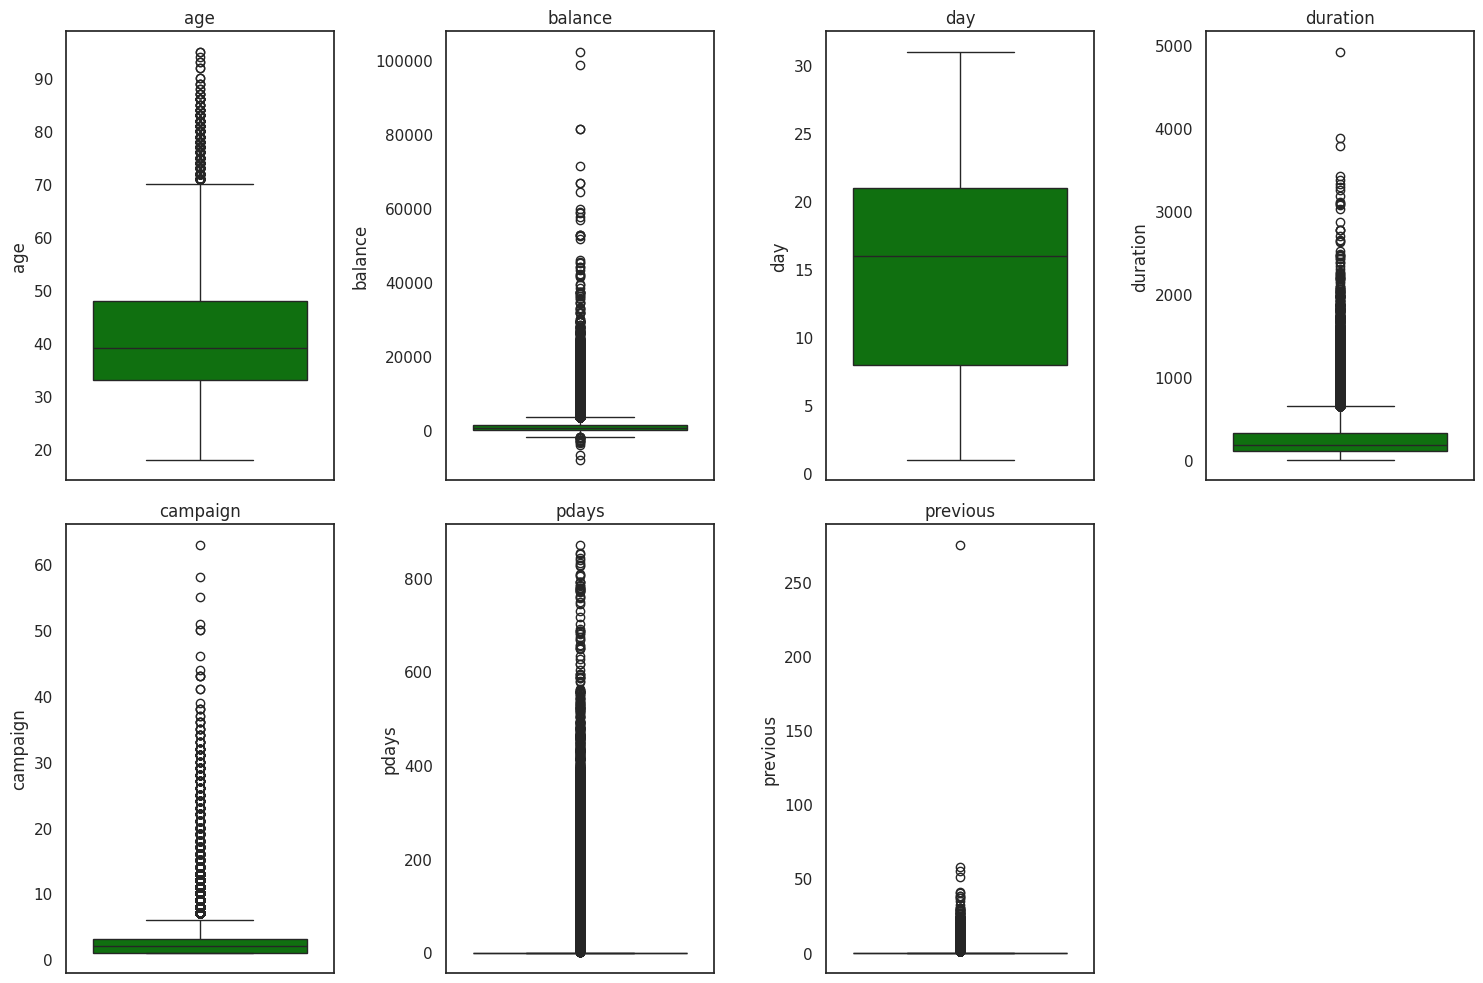

In [15]:
# cek outlier menggunakan boxplot pada fitur balance
plt.figure(figsize=(15, 10))
for i in range(len(nums)):
    plt.subplot(2, 4, i+1)
    sns.boxplot(df[nums[i]], color='g')
    plt.title(nums[i])
plt.tight_layout()
plt.show()

Berdasarkan boxplot yang dihasilkan, beberapa fitur numerik dalam dataset menunjukkan adanya outlier.  Outlier ini terlihat sebagai titik-titik data yang berada di luar batas *whisker* pada boxplot. Fitur-fitur seperti **balance**, **duration**, **campaign**, dan **pdays** memiliki outlier yang cukup signifikan.  Keberadaan outlier ini mengindikasikan adanya data yang berbeda jauh dari mayoritas data lainnya dan berpotensi memengaruhi hasil analisis dan pemodelan selanjutnya.  Untuk langkah selanjutnya, perlu dipertimbangkan penanganan outlier, misalnya dengan melakukan *winsorization*, *trimming*, atau teknik lainnya, agar model yang dibangun lebih robust dan akurat.

In [16]:
# total data sebelum dlakukan outlier removal
df.shape[0]

45211

In [17]:
# hapus outlier pada fitur yg menunjukkan potensi outlier menggunakan iqr

# fungsi hapus outlier
def remove_outlier(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# hapus outlier pada data
for col in nums:
    df = remove_outlier(df, col)

# cek data setelah dilakukan outlier removal
df.shape[0]

28069

total data setelah dilakukan tahap preprocessing menjadi 28069, ini menandakan bahwa data sebelum di preprocessing sangat kotor

## Feature Engineering

In [18]:
# cek two uniq fitur pada dataset
df[two_uniq_fitur].head()

,default,housing,loan,y
0,no,yes,no,no
1,no,yes,no,no
2,no,yes,yes,no
3,no,yes,no,no
4,no,no,no,no


In [19]:
# mengubah nilai no ke 0 dan yes ke 1
for i in two_uniq_fitur:
    df[i] = df[i].map({'no': 0, 'yes': 1})

# cek setelah di replace
df[two_uniq_fitur].head()

,default,housing,loan,y
0,0,1,0,0
1,0,1,0,0
2,0,1,1,0
3,0,1,0,0
4,0,0,0,0


In [20]:
# label encoder untuk fitur month
le = LabelEncoder()
df['month'] = le.fit_transform(df['month'])
df['month'].head()

,month
0,8
1,8
2,8
3,8
4,8


In [21]:
# cek class le pada fitur month
le.classes_

array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
       'nov', 'oct', 'sep'], dtype=object)

ini menunjukkan bahwa nilai apr menjadi 0 lalu aug menjadi 1 dan seterusnya

In [22]:
# cek more uniq fitur pada dataset
more_uniq_fitur = list(more_uniq_fitur)
# menghapus fitur month karena sudah di encoding menggunakan le
more_uniq_fitur.remove('month')

df[more_uniq_fitur].head()

,job,marital,education,contact,poutcome
0,management,married,tertiary,unknown,unknown
1,technician,single,secondary,unknown,unknown
2,entrepreneur,married,secondary,unknown,unknown
3,blue-collar,married,unknown,unknown,unknown
4,unknown,single,unknown,unknown,unknown


In [23]:
# one hot encoder untuk fitur kategorik non ordinal
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

df_ohe = pd.DataFrame(ohe.fit_transform(df[more_uniq_fitur]), columns=ohe.get_feature_names_out())
df = pd.concat([df, df_ohe], axis=1)

# menghapus fitur job	marital	education	contact	poutcome, karena sudah di encode.. jadi tidak diperlukan lagi
df.drop(more_uniq_fitur, axis=1, inplace=True)
df.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown
0,58.0,0.0,2143.0,1.0,0.0,5.0,8.0,261.0,1.0,-1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,44.0,0.0,29.0,1.0,0.0,5.0,8.0,151.0,1.0,-1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,33.0,0.0,2.0,1.0,1.0,5.0,8.0,76.0,1.0,-1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,47.0,0.0,1506.0,1.0,0.0,5.0,8.0,92.0,1.0,-1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,33.0,0.0,1.0,0.0,0.0,5.0,8.0,198.0,1.0,-1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [24]:
# # cek nilai null setelah dilakukan encoding
df.isnull().sum()

,0
age,7692
default,7692
balance,7692
housing,7692
loan,7692
day,7692
month,7692
duration,7692
campaign,7692
pdays,7692


In [26]:
# hapus nilai null
df.dropna(inplace=True)

In [27]:
# cek info dataset lagi stelah feature engineering dan drop null value
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20377 entries, 0 to 28068
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  20377 non-null  float64
 1   default              20377 non-null  float64
 2   balance              20377 non-null  float64
 3   housing              20377 non-null  float64
 4   loan                 20377 non-null  float64
 5   day                  20377 non-null  float64
 6   month                20377 non-null  float64
 7   duration             20377 non-null  float64
 8   campaign             20377 non-null  float64
 9   pdays                20377 non-null  float64
 10  previous             20377 non-null  float64
 11  y                    20377 non-null  float64
 12  job_blue-collar      20377 non-null  float64
 13  job_entrepreneur     20377 non-null  float64
 14  job_housemaid        20377 non-null  float64
 15  job_management       20377 non-null  floa

karena semua fitur sudah menjadi numerik semua maka kita bisa lanjut ke next step yaitu modelling dengan total akhir data sebesar 20377

## Data Modelling

In [28]:
# data splitting
X = df.drop('y', axis=1)
y = df['y']

# cek apakah fitur y sudah balance
y.value_counts()

,count
y,
0.0,20028
1.0,349


karena class 0 dan class 1 tidak seimbang, maka akan mempengaruhi hasil dari model kita.. oleh karena itu saya akan menggunakan SMOTEENN untuk menyeimbangkan kedua class tersebut

SMOTE-ENN (Synthetic Minority Over-sampling Technique - Edited Nearest Neighbors) adalah teknik penyeimbangan dataset yang menggabungkan oversampling untuk meningkatkan jumlah sampel minoritas dengan SMOTE dan pembersihan data menggunakan ENN.

In [29]:
# inisialisasi smoteenn
smoteenn = SMOTEENN(random_state=42)

# fit_resample
X_res, y_res = smoteenn.fit_resample(X, y)

In [30]:
# cek fitur y kembali
y_res.value_counts()

,count
y,
1.0,18944
0.0,16466


sekarng agak mendingan daripada sebelumnya, setidaknya sudah cukup balance untuk dilakukan modelling

In [31]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

In [32]:
# inisialisasi decision tree classifier
dtr = DecisionTreeClassifier()

# params untuk gridsearch
params = {
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 6, 8],
    'random_state': [0, 42]
}

# inisialisasi gridsearchcv
grid_dtr = GridSearchCV(estimator=dtr, param_grid=params, cv=3, n_jobs=-1)

# fit gridsearch
grid_dtr.fit(X_train, y_train)

# menampilkan best parameters
print('Best Hyperparameters:', grid_dtr.best_params_)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0}


In [33]:
# menyimpan best estimator ke variabel dtr
dtr = grid_dtr.best_estimator_

In [34]:
# fitting train data
dtr.fit(X_train, y_train)

# prediksi test data
y_pred = dtr.predict(X_test)

## Model Evaluation

In [35]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      3293
         1.0       0.99      0.99      0.99      3789

    accuracy                           0.99      7082
   macro avg       0.99      0.99      0.99      7082
weighted avg       0.99      0.99      0.99      7082



Berdasarkan classification report di atas, model menunjukkan performa yang sangat baik dalam mengklasifikasikan dua kelas. Dengan akurasi mencapai 99%, baik untuk kelas 0.0 maupun 1.0, precision dan recall keduanya juga tinggi, masing-masing 0.99. F1-score yang mencapai 0.99 untuk kedua kelas menunjukkan keseimbangan yang baik antara presisi dan recall. Rata-rata makro dan tertimbang juga menunjukkan nilai yang konsisten di semua metrik, menandakan model dapat diandalkan dalam melakukan prediksi. Secara keseluruhan, model ini sangat efektif dalam menangani dataset ini.

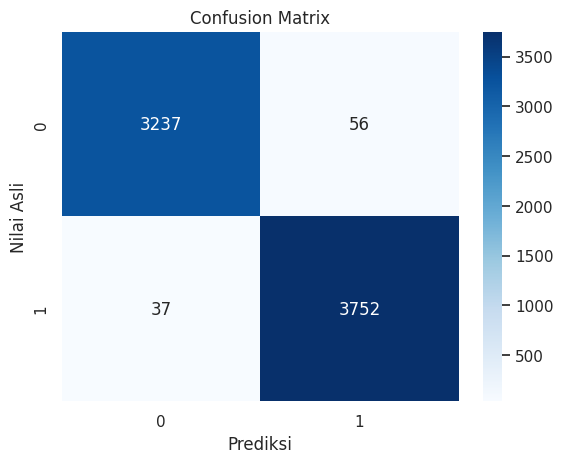

In [36]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Nilai Asli')
plt.title('Confusion Matrix')
plt.show()

Berdasarkan confusion matrix yang dihasilkan, model memiliki performa yang sangat baik dalam mengklasifikasikan data.

* **Akurasi tinggi:**  Model mampu memprediksi dengan benar sebagian besar data, ditunjukkan oleh jumlah prediksi yang benar pada diagonal utama confusion matrix.
* **Sedikit kesalahan prediksi:**  Hanya terdapat sedikit kesalahan dalam mengklasifikasikan data, baik memprediksi kelas positif sebagai negatif maupun sebaliknya.
* **Keseimbangan klasifikasi:** Model mampu memprediksi kelas positif dan negatif dengan baik, tidak ada kecenderungan untuk memprediksi salah satu kelas lebih sering daripada yang lain.

Secara keseluruhan, model yang dihasilkan dapat diandalkan dalam melakukan klasifikasi, dengan tingkat akurasi dan presisi yang tinggi, serta keseimbangan dalam memprediksi kedua kelas.

In [38]:
# feature importance
dtr_fi = dtr.feature_importances_
dtr_fi_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': dtr_fi})
dtr_fi_df = dtr_fi_df.sort_values(by='Importance', ascending=False)
dtr_fi_df.head()

,Feature,Importance
7,duration,0.638570
6,month,0.131833
24,education_secondary,0.042324
28,contact_unknown,0.030648
5,day,0.026176


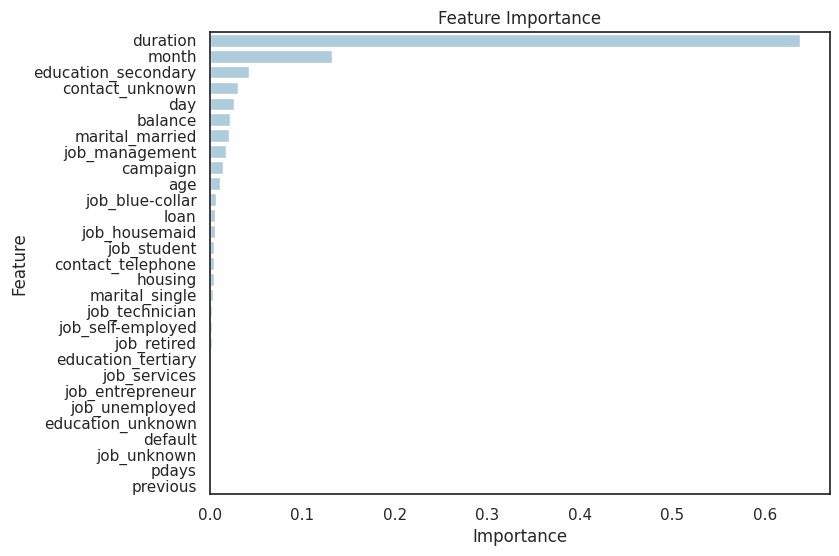

In [40]:
# visualisasi
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=dtr_fi_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Berdasarkan analisis feature importance, beberapa fitur memiliki pengaruh yang signifikan terhadap model dalam memprediksi target. Fitur 'duration' (durasi panggilan) dan 'month' memiliki bobot importance yang tinggi, menandakan bahwa durasi panggilan dan riwayat kontak sebelumnya berpengaruh besar terhadap model.

dan untuk fitur lainnya tidak memiliki bobot yg begitu tinggi dan bahkan ada fitur yang tidak memiliki bobot sama sekali.